
# Análise de Marcha
**Bruno da Silva Cunha**

Universidade Federal do Espírio Santo

**3. Download, Crop e Gerar Keyframes**

Pipeline completo e comentado para **classificação de `gait_pat`** usando **keypoints** (poses) gerados pelo YOLO.
Este notebook segue **boas práticas** de ML, com **split por grupos (`id`)** para evitar vazamento e **validação robusta**.



**Arquitetura dos dados (no Google Drive):**
```
/estudos/IA_CD/Modelo_Treino_Marcha/
  processed_videos_data.csv
  /processed/poses/
    {id}_poses.npy   # array [T, 17, 3]
```
- A coluna alvo: **`gait_pat`**
- Há **vídeos repetidos** → vamos **agrupar/deduplicar por `id`** para treinamento justo.

In [2]:

#@title 🔧 Checagens de runtime e instalações (execute uma vez por sessão)
import sys, platform, numpy as np, pandas as pd
print("Python:", sys.version)
print("Platform:", platform.platform())

!pip install -q imbalanced-learn
!pip install -q scikit-learn

import sklearn
print("sklearn:", sklearn.__version__)

try:
    import torch
    print("PyTorch:", torch.__version__)
    print("CUDA disponível:", torch.cuda.is_available())
except Exception as e:
    print("PyTorch não disponível (ok para este notebook).")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
sklearn: 1.6.1
PyTorch: 2.8.0+cu126
CUDA disponível: True


## 🔗 Conectar ao Google Drive e configurar caminhos

In [3]:

#@title Montar Google Drive e configurar diretórios base
from pathlib import Path

USE_GOOGLE_DRIVE = True  #@param {type:"boolean"}
BASE_DIR = "/Estudos/IA_CD/Modelo_Treino_Marcha"  #@param {type:"string"}
CSV_NAME = "processed_videos_data.csv"  #@param {type:"string"}
POSES_DIR_REL = "processed/poses"  #@param {type:"string"}

if USE_GOOGLE_DRIVE:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=True)
    ROOT = Path("/content/drive/MyDrive").resolve()
else:
    ROOT = Path(".").resolve()

BASE_PATH = ROOT / BASE_DIR.strip("/")
POSES_DIR = BASE_PATH / POSES_DIR_REL.strip("/")
CSV_PATH = BASE_PATH /f"data/{CSV_NAME}"

print("ROOT:", ROOT)
print("BASE_PATH:", BASE_PATH)
print("CSV_PATH:", CSV_PATH)
print("POSES_DIR:", POSES_DIR)


Mounted at /content/drive
ROOT: /content/drive/MyDrive
BASE_PATH: /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha
CSV_PATH: /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/processed_videos_data.csv
POSES_DIR: /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/processed/poses


## 📥 Carregar e preparar o dataframe

In [4]:

#@title Carregar CSV, checar colunas e deduplicar por `id`
import pandas as pd

assert CSV_PATH.exists(), f"CSV não encontrado em {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
print("Shape inicial:", df.shape)
print("Colunas:", df.columns.tolist())

required_cols = {"id", "gait_pat"}
missing = required_cols - set(df.columns)
assert not missing, f"Colunas faltando no CSV: {missing}"

df = df.dropna(subset=["gait_pat"])

df = df.sort_values("id")
df_dedup = df.drop_duplicates(subset=["id"], keep="first").copy()
print("Após deduplicação por id:", df_dedup.shape)

df_dedup["gait_pat"] = df_dedup["gait_pat"].astype(str).str.strip()

id_to_label = dict(zip(df_dedup["id"], df_dedup["gait_pat"]))

class_counts = df_dedup["gait_pat"].value_counts().sort_index()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ["gait_pat", "count"]
class_counts_df


Shape inicial: (446, 17)
Colunas: ['seq', 'frame_num', 'cam_view', 'gait_pat', 'id', 'url', 'min_frame', 'max_frame', 'get_info_success', 'fps', 'start_time', 'end_time', 'download_video_success', 'video_path', 'crop_path', 'multi_person', 'poses_path']
Após deduplicação por id: (69, 17)


,gait_pat,count
0,antalgic,3
1,cerebral palsy,4
2,inebriated,4
3,myopathic,14
4,normal,22
5,parkinsons,6
6,prosthetic,6
7,stroke,8
8,style,2


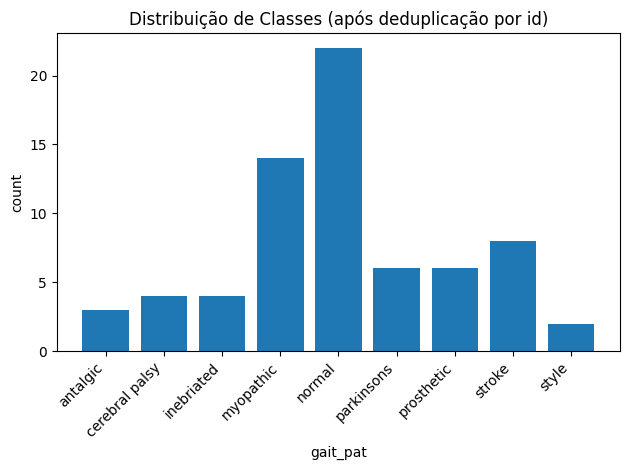

In [5]:

#@title 📊 Distribuição de classes
import matplotlib.pyplot as plt

plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Distribuição de Classes (após deduplicação por id)")
plt.xlabel("gait_pat")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## 🧩 Carregar `poses` (.npy) e construir dataset

In [8]:
# 👉 SUBSTITUA a função extract_features_from_pose por esta e re-execute a célula de "Construir dataset X, y ..."
import numpy as np

def extract_features_from_pose(seq):
    """
    Extrai features robustas de [T, 17, 3] (usa só x,y e conf se existir).
    Faz normalização por bbox frame-a-frame e estatísticas no tempo,
    com máscaras compatíveis com o número de canais.
    """
    T, J, C = seq.shape  # esperado C>=2 (x,y[,conf])
    xy = seq[..., :2].astype(np.float32)                 # [T, 17, 2]
    conf = seq[..., 2] if C >= 3 else np.ones((T, J), dtype=np.float32)  # [T, 17]

    # keypoints válidos
    valid = conf > 0                                      # [T, 17]

    # Normalização por bbox por frame (reduce variância de posição/escala)
    xy_norm = xy.copy()
    for t in range(T):
        vmask = valid[t]
        if vmask.any():
            pts = xy[t, vmask, :]                         # [Nv, 2]
            min_xy = pts.min(axis=0)
            max_xy = pts.max(axis=0)
            scale = (max_xy - min_xy)
            scale[scale == 0] = 1.0
            xy_norm[t, vmask, :] = (xy[t, vmask, :] - min_xy) / scale
        else:
            xy_norm[t, :, :] = 0.0

    # Velocidade aproximada (diferença temporal) + padding p/ manter T
    vel = np.diff(xy_norm, axis=0)                        # [T-1, 17, 2]
    vel = np.concatenate([vel, np.zeros((1, J, 2), dtype=vel.dtype)], axis=0)  # [T, 17, 2]

    # ------- Máscaras compatíveis com os canais -------
    # Para posições (2 canais: x,y)
    mask_xy = np.repeat(valid[..., None], 2, axis=2)      # [T, 17, 2]

    # Para velocidades (2 canais) — exigimos válidos em t e t-1
    valid_pairs = np.logical_and(valid, np.roll(valid, 1, axis=0))  # [T, 17]
    valid_pairs[0, :] = False                              # 1º frame não tem velocidade "real"
    mask_vel = np.repeat(valid_pairs[..., None], 2, axis=2)  # [T, 17, 2]

    def stats_over_time(arr, mask=None):
        # arr: [T, 17, D], mask: [T, 17, D] ou None
        A = arr.reshape(T, -1)                             # [T, 17*D]
        if mask is not None:
            M = mask.reshape(T, -1)                        # [T, 17*D]
            A = np.where(M, A, np.nan)
            mean   = np.nanmean(A, axis=0)
            std    = np.nanstd(A, axis=0)
            amin   = np.nanmin(A, axis=0)
            amax   = np.nanmax(A, axis=0)
            median = np.nanmedian(A, axis=0)
        else:
            mean   = A.mean(axis=0)
            std    = A.std(axis=0)
            amin   = A.min(axis=0)
            amax   = A.max(axis=0)
            median = np.median(A, axis=0)
        return np.concatenate([mean, std, amin, amax, median], axis=0).astype(np.float32)

    feats_xy  = stats_over_time(xy_norm, mask_xy)         # posições com máscara nos 2 canais
    feats_vel = stats_over_time(vel, mask_vel)            # velocidades com máscara nos 2 canais

    # Proporção de keypoints válidos por frame (para qualidade/confiança)
    valid_ratio_per_frame = valid.mean(axis=1).astype(np.float32)   # [T]
    conf_feats = np.array([
        valid_ratio_per_frame.mean(),
        valid_ratio_per_frame.std(),
        valid_ratio_per_frame.min(),
        valid_ratio_per_frame.max(),
        np.median(valid_ratio_per_frame),
    ], dtype=np.float32)

    feats = np.concatenate([feats_xy, feats_vel, conf_feats], axis=0).astype(np.float32)
    return feats


In [11]:

#@title Construir dataset X, y com base nos arquivos {id}_poses.npy
from tqdm import tqdm
import numpy as np

ids = df_dedup["id"].astype(str).tolist()
labels = []
groups = []
features = []

missing_pose = 0
for vid in tqdm(ids, desc="Carregando poses e extraindo features"):
    pose_path = POSES_DIR / f"{vid}_poses.npy"
    seq = safe_load_pose(pose_path)
    if seq is None:
        print("❌ Ausente:", vid)
        missing_pose += 1
        continue
    x = extract_features_from_pose(seq)
    features.append(x)
    labels.append(id_to_label[vid])
    groups.append(vid)

X = np.vstack(features).astype(np.float32) if len(features) > 0 else np.empty((0,))
y = np.array(labels)
groups = np.array(groups)

print("Amostras construídas:", len(y))
print("Shape de X:", X.shape)
print("Poses ausentes/ inválidas:", missing_pose)

assert len(X) == len(y) == len(groups), "X, y, groups com tamanhos inconsistentes."


Carregando poses e extraindo features:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipython-input-432657645.py:50: RuntimeWarning: Mean of empty slice
  mean   = np.nanmean(A, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-432657645.py:52: RuntimeWarning: All-NaN slice encountered
  amin   = np.nanmin(A, axis=0)
/tmp/ipython-input-432657645.py:53: RuntimeWarning: All-NaN slice encountered
  amax   = np.nanmax(A, axis=0)
/tmp/ipython-input-432657645.py:54: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(A, axis=0)
Carregando poses e extraindo features:  12%|█▏        | 8/69 [00:00<00:01, 38.47it/s]

❌ Ausente: 3FXUw98rrUY
❌ Ausente: 3KnFt8bH3tE
❌ Ausente: 4KU6G7Iv8ZM
❌ Ausente: 7nIQv3K_-Qc
❌ Ausente: 8mTHlAIdea0
❌ Ausente: 9126Bdjn8sg


Carregando poses e extraindo features:  25%|██▍       | 17/69 [00:00<00:01, 35.07it/s]

❌ Ausente: CMls0LwK5OU
❌ Ausente: EHymg4AGMJs
❌ Ausente: FTHc-TJOQ34


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1233: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
Carregando poses e extraindo features:  36%|███▌      | 25/69 [00:00<00:01, 31.53it/s]

❌ Ausente: IuEeKzqsfmk
❌ Ausente: KnvYRnTA3XQ


Carregando poses e extraindo features:  46%|████▋     | 32/69 [00:01<00:01, 25.94it/s]

❌ Ausente: QO8D-comBy8
❌ Ausente: RMdC8Pa3VbU
❌ Ausente: SiYe89_WaTQ
❌ Ausente: USurcA3YKDY
❌ Ausente: VL0AOiZt_lg
❌ Ausente: aqUuTLh6pHk
❌ Ausente: dvfeYnWVD08


Carregando poses e extraindo features:  75%|███████▌  | 52/69 [00:01<00:00, 53.67it/s]

❌ Ausente: eBvzFkcvScg
❌ Ausente: eCCYhDSDlDc
❌ Ausente: gp4H7Z2Vvn0
❌ Ausente: hSIYGZhRGd4
❌ Ausente: lhDa_7coFz4
❌ Ausente: mu00TaRG7VU
❌ Ausente: nXuJIs25z1U


Carregando poses e extraindo features:  86%|████████▌ | 59/69 [00:01<00:00, 55.70it/s]

❌ Ausente: pFLC9C-xH8E


Carregando poses e extraindo features: 100%|██████████| 69/69 [00:01<00:00, 38.00it/s]

Amostras construídas: 43
Shape de X: (43, 345)
Poses ausentes/ inválidas: 26


## 🔀 Split de treino/val/teste com **grupos por `id`**

In [17]:
#@title Criar splits: holdout de teste por grupo e CV interno no treino (folds dinâmicos)
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
y_enc = le.fit_transform(y)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_enc, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_enc[train_idx], y_enc[test_idx]
groups_train = groups[train_idx]

print("Train size:", X_train.shape, " Test size:", X_test.shape)

# nº de folds = min(5, tamanho da classe minoritária no TREINO), mas pelo menos 2
counts = np.bincount(y_train)
min_per_class = counts[counts > 0].min()
n_splits = int(max(2, min(5, min_per_class)))
print(f"Usando StratifiedGroupKFold com n_splits={n_splits} (classe minoritária no treino = {min_per_class})")

cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

# (opcional e útil) sanitize de infinitos -> NaN, para o Imputer tratar
X_train = np.where(np.isfinite(X_train), X_train, np.nan)
X_test  = np.where(np.isfinite(X_test),  X_test,  np.nan)


Train size: (34, 345)  Test size: (9, 345)
Usando StratifiedGroupKFold com n_splits=2 (classe minoritária no treino = 2)


## 🤖 Modelos e busca de hiperparâmetros (com `Pipeline`)

In [18]:
#@title Definir modelos candidatos e rodar busca simples (com Imputer e f1_macro)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

imputer = SimpleImputer(strategy="median")

models = {
    "logreg": Pipeline([
        ("imputer", imputer),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "ridge": Pipeline([
        ("imputer", imputer),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", RidgeClassifier())
    ]),
    "svc_linear": Pipeline([
        ("imputer", imputer),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", SVC(kernel="linear", probability=True, class_weight="balanced"))
    ]),
    "rf": Pipeline([
        ("imputer", imputer),
        ("clf", RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=42))
    ]),
}

param_grids = {
    "logreg": { "clf__C": [0.1, 1.0, 10.0] },
    "ridge":  { "clf__alpha": [0.1, 1.0, 10.0] },
    "svc_linear": { "clf__C": [0.1, 1.0, 10.0] },
    "rf": { "clf__n_estimators": [200, 500], "clf__max_depth": [None, 10, 20] }
}

results = []
best_model = None
best_name = None
best_score = -np.inf

for name, pipe in models.items():
    print(f"\n=== {name} ===")
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="f1_macro",                   # 👈 scorer explícito multiclass
        cv=cv.split(X_train, y_train, groups_train),
        n_jobs=-1,
        refit=True,
        error_score="raise"                   # ou "nan" para não quebrar
    )
    grid.fit(X_train, y_train)
    print("Melhor params:", grid.best_params_)
    print("CV F1-macro:", grid.best_score_)
    results.append((name, grid.best_score_, grid.best_params_))
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

print("\nMelhor modelo:", best_name, "com CV F1-macro:", best_score)



=== logreg ===
Melhor params: {'clf__C': 0.1}
CV F1-macro: 0.049107142857142856

=== ridge ===
Melhor params: {'clf__alpha': 10.0}
CV F1-macro: 0.04197588126159554

=== svc_linear ===
Melhor params: {'clf__C': 10.0}
CV F1-macro: 0.05133928571428571

=== rf ===
Melhor params: {'clf__max_depth': None, 'clf__n_estimators': 200}
CV F1-macro: 0.06428571428571428

Melhor modelo: rf com CV F1-macro: 0.06428571428571428


## 📏 Avaliação no conjunto de teste (holdout por grupo)

In [ ]:

#@title Métricas, matriz de confusão, ROC/PR e curvas de aprendizado
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("=== Classification Report (Teste) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Matriz de Confusão (Teste)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45, ha="right")
plt.yticks(np.arange(len(le.classes_)), le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        exp = np.exp(scores - scores.max(axis=1, keepdims=True))
        proba = exp / exp.sum(axis=1, keepdims=True)
        return proba
    else:
        preds = model.predict(X)
        proba = np.zeros((len(preds), len(le.classes_)))
        proba[np.arange(len(preds)), preds] = 1.0
        return proba

y_proba = get_proba(best_model, X_test)

plt.figure()
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC OvR (Teste)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for i, cls in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_proba[:, i])
    plt.plot(recall, precision, label=f"{cls}")
plt.title("Precision-Recall OvR (Teste)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

#@title Curva de aprendizado (estimativa)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=cv.split(X_train, y_train, groups_train),
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="f1_macro",
    n_jobs=-1
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Treino")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validação (CV)")
plt.title("Curva de Aprendizado (F1-macro)")
plt.xlabel("Tamanho do treino")
plt.ylabel("F1-macro")
plt.legend()
plt.tight_layout()
plt.show()


## 💾 Salvar artefatos (modelo, encoder e features)

In [ ]:

#@title Salvar modelo, encoder e metadados no Drive
import joblib
from pathlib import Path
import numpy as np

MODELS_DIR = BASE_PATH / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, MODELS_DIR / "best_model.joblib")
joblib.dump(le, MODELS_DIR / "label_encoder.joblib")
np.save(MODELS_DIR / "X_train.npy", X_train)
np.save(MODELS_DIR / "y_train.npy", y_train)
np.save(MODELS_DIR / "X_test.npy", X_test)
np.save(MODELS_DIR / "y_test.npy", y_test)

print("Artefatos salvos em:", MODELS_DIR)


## 🔮 Inferência em novos vídeos (a partir de `{id}_poses.npy`)

In [ ]:

#@title Função de inferência por id
def predict_gait_pat_from_id(video_id: str) -> str:
    path = POSES_DIR / f"{video_id}_poses.npy"
    seq = safe_load_pose(path)
    assert seq is not None, f"Arquivo não encontrado ou inválido: {path}"
    x = extract_features_from_pose(seq).reshape(1, -1)
    pred = best_model.predict(x)[0]
    return le.inverse_transform([pred])[0]

# Exemplo (troque "SOME_ID" por um id válido):
# predict_gait_pat_from_id("SOME_ID")



---
### 📝 Notas e extensões
- **Balanceamento**: usamos `class_weight="balanced"` em alguns modelos. Para técnicas de *resampling* (ex.: `RandomUnderSampler`), adicione após o split e **antes** do CV.
- **Feature engineering**: você pode enriquecer com **ângulos articulares**, **simetria esquerda/direita**, FFT de trajetórias, etc.
- **Modelos**: testar GradientBoosting, XGBoost/LightGBM (quando disponíveis) e redes profundas (1D-CNN/LSTM) caso tenha recursos.
- **Validação**: mantivemos **Group-aware** (por `id`) para evitar vazamento entre vídeos do mesmo indivíduo/grupo.
- **Reprodutibilidade**: fixe `random_state` onde possível e registre versões de libs.
